In [ ]:
import random
from sklearn.preprocessing import LabelEncoder


DATA_PATH = "SMSSpamCollection"


def encode_classes(class1: str, class2: str):
  """
  Encodes the classes for the models

  :param class1: the "HAM" class
  :type class1: str
  :param class2: the "SPAM" class
  :type class2: str
  :return encoded: array of encoded classes ([0 1])
  :rtype: numpy.ndarray
  """
  encoder = LabelEncoder()
  encoded = encoder.fit_transform([class1, class2])

  return encoded


def generate_dataset(file_path: str):
  """
  Reading the data from the file and creating a dataset

  :param file_path: absolute path to the file
  :type file_path: str
  :return dataset: list of lists containing the data and the classes
  :rtype: list
  """
  dataset = list()
  encoded = encode_classes("ham", "spam")
  class_dict = {"ham": encoded[0], "spam": encoded[1]}

  with open(file=file_path, mode='r') as datafile:
    for line in datafile.readlines():
      line = line.rstrip("\n").split("\t")
      label = line[0]
      text = line[1]
      dataset.append([text, class_dict[label]])
  
  return dataset


def split_dataset(dataset: list):
  """
  Splits the dataset into training, validation and test datasets in ratio 60:20:20

  :param dataset: the complete dataset
  :type dataset: list
  :returns:
    - train_set - list of training data, type: list
    - val_set - list of validation data, type: list
    - test_set - list of test data, type: list
  """
  split_1 = int(len(dataset) * 0.6)
  split_2 = int(len(dataset) * 0.8)

  train_set = dataset[:split_1]
  val_set = dataset[split_1:split_2]
  test_set = dataset[split_2:]

  return train_set, val_set, test_set


if __name__ == '__main__':
  data = generate_dataset(DATA_PATH)
  print(f"Dataset size: {len(data)}")

  train_data, validation_data, test_data = split_dataset(data)
  print(f"Train data size: {len(train_data)}")
  print(f"Validation data size: {len(validation_data)}")
  print(f"Test data size: {len(test_data)}")

  print(f"Sample of train_data before preprocessing: {train_data[0]}")

Dataset size: 5574
Train data size: 3344
Validation data size: 1115
Test data size: 1115
Sample of train_data before preprocessing: ['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


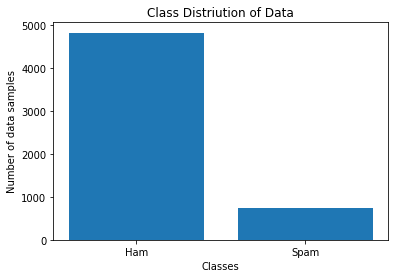


Sample from processed_train_data after removing punctuation and stop words, and making letters lowercase: ['go jurong point crazy available bugis n great world la e buffet cine got amore wat', 0]
Vocabulary length: 9530


In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def visualize_class_distribution(dataset: list):
  """
  Function that visualizes data distribution over the classes

  :param dataset: the complete dataset
  :type dataset: list
  :returns: None
  """
  ham_counter = 0
  spam_counter = 0

  for data in dataset:
    if data[1] == 0:
      ham_counter += 1
    else:
      spam_counter += 1

  classes = ["Ham", "Spam"]
  values = [ham_counter, spam_counter]

  plt.bar(classes, values)
  plt.title("Class Distriution of Data")
  plt.xlabel("Classes")
  plt.ylabel("Number of data samples")
  plt.show()


def remove_punctuation_and_make_letters_lowercase(dataset: list):
  """
  Function that removes punctuation marks from the messages and makes all letters lowercase

  :param dataset: a set of SMS data and their classes
  :type dataset: list
  :return dataset: the same set of data, without punctuation marks and letters made lowercase
  :rtype: list
  """
  for element in dataset:
    text = element[0]
    processed_text = "".join([char.lower() for char in text if char not in punctuation])
    element[0] = processed_text
  
  return dataset


def remove_stop_words(dataset: list):
  """
  Removes stop words from the messages

  :param dataset: a set of SMS data and their classes
  :type dataset: list
  :return dataset: the same set of data, however stop words are removed
  :rtype: list
  """
  stop_words = stopwords.words("english")

  for element in dataset:
    text_splitted = element[0].split()
    processed = " ".join([word for word in text_splitted if word not in stop_words])
    element[0] = processed

  return dataset


def create_vocabulary(dataset: list):
  """
  Creates a vocabulary from the entire dataset

  :param dataset: the entire dataset, preprocessed
  :type dataset: list
  :return vocab: a vocabulary from the entire corpus
  :rtype: set
  """
  vocab = set()

  for element in dataset:
    words = element[0].split()
    for word in words:
      vocab.add(word)
  
  return vocab


def create_bag_of_words_dictionary(dataset: list):
  """
  Creates a dictionary where words are the keys and the values are the number of occurences of the corresponding word in the entire corpus

  :param dataset: the entire dataset, preprocessed
  :type dataset: list
  :return bow: a dictionary of the form {word: word_occurences_in_corpus}
  :rtype: dict
  """
  bow = dict()

  for element in dataset:
    words = element[0].split()
    for word in words:
      if word in bow.keys():
        bow[word] += 1
      else:
        bow[word] = 1

  return bow


def map_texts_to_bow_vectors(dataset: list, bow: dict):
  """
  Maps each text in a Bag of Words vector

  :param dataset: the entire dataset, preprocessed
  :type dataset: list
  :param bow: a dictionary of the form {word: word_occurences_in_corpus}
  :type bow: dict
  :return bow_dataset: the entire dataset in the form [[bag_of_words_vector], label], ...]
  :rtype: list
  """
  bow_dataset = list()

  for element in dataset:
    words = element[0].split()
    bow_features = [bow[word] for word in words]
    bow_dataset.append([bow_features, element[1]])

  return bow_dataset


def split_data_and_labels(dataset: list):
  """
  Splits the data and classes from the dataset

  :param dataset: a set of SMS data and their classes
  :type dataset: list
  """
  splitted_data = [x[0] for x in dataset]
  classes = [x[1] for x in dataset]

  return splitted_data, classes


if __name__ == '__main__':
  visualize_class_distribution(data)
  print('')
  # Classes need weigths because we don't have an uniform distribution of the data over the classes

  # Removing punctuation marks and making letters lowercase
  processed_train_data = remove_punctuation_and_make_letters_lowercase(train_data)
  processed_validation_data = remove_punctuation_and_make_letters_lowercase(validation_data)
  processed_test_data = remove_punctuation_and_make_letters_lowercase(test_data)

  # Next, we need to remove stopwords, because they don't give any value to the text
  processed_train_data = remove_stop_words(processed_train_data)
  processed_validation_data = remove_stop_words(processed_validation_data)
  processed_test_data = remove_stop_words(processed_test_data)

  print(f"Sample from processed_train_data after removing punctuation and stop words, and making letters lowercase: {processed_train_data[0]}")

  # Defining vocabulary for the entire dataset
  data = processed_train_data + processed_validation_data + processed_test_data
  vocabulary = create_vocabulary(data)
  print(f'Vocabulary length: {len(vocabulary)}')

  # Creating Bag of Words vectors
  bow_dict = create_bag_of_words_dictionary(data)
  ## Mapping each dataset to the form [[bag_of_words_feature_vector], class], ...]
  bow_train_data = map_texts_to_bow_vectors(processed_train_data, bow_dict)
  bow_test_data = map_texts_to_bow_vectors(processed_test_data, bow_dict)

  # Creating TF-IDF vectors
  vectorizer = TfidfVectorizer()

  train_X, train_Y = split_data_and_labels(processed_train_data)
  validation_X, validation_Y = split_data_and_labels(processed_validation_data)
  test_X, test_Y = split_data_and_labels(processed_test_data)

  vectorizer.fit(train_X + test_X)
  tfidf_train_X = vectorizer.transform(train_X)
  tfidf_test_X = vectorizer.transform(test_X)

  # Tokenizing for Keras model
  keras_tokenizer = Tokenizer()

  keras_data = train_X + validation_X + test_X
  keras_tokenizer.fit_on_texts(keras_data)

  keras_train_X = keras_tokenizer.texts_to_sequences(train_X)
  keras_validation_X = keras_tokenizer.texts_to_sequences(validation_X)
  keras_test_X = keras_tokenizer.texts_to_sequences(test_X)

  ## Padding sequences to same length
  train_length = max(map(len, keras_train_X))
  val_length = max(map(len, keras_validation_X))
  test_length = max(map(len, keras_test_X))

  length = max(train_length, val_length, test_length)
  keras_train_X = pad_sequences(keras_train_X, maxlen=length)
  keras_validation_X = pad_sequences(keras_validation_X, maxlen=length)
  keras_test_X = pad_sequences(keras_test_X, maxlen=length) 

In [ ]:
# Creating some ML models
import numpy as np
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score


# Creating weights for the classes
classes = [x[1] for x in data]
class_weights = class_weight.compute_class_weight('balanced', np.unique(classes), classes)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# Converting BoW data and classes to numpy arrays
bow_train_X, train_Y = split_data_and_labels(bow_train_data)
bow_test_X, test_Y = split_data_and_labels(bow_test_data)
## Padding Bag of Words feature vectors to same length (max length of feature vectors from the entire dataset)
bow_train_max_len = max(map(len, bow_train_X))
bow_test_max_len = max(map(len, bow_test_X))

length = max(bow_train_max_len, bow_test_max_len)
bow_train_X = np.array([x + [0] * (length - len(x)) for x in bow_train_X])
bow_test_X = np.array([x + [0] * (length - len(x)) for x in bow_test_X])

train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

# Creating a logistic regression model for the Bag of Words data
## First we use GridSearchCV to look for optimal parameter values
### logistic_regression_parameters = {'C': [1, 10, 100, 250, 500], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
### logistic_regression = LogisticRegression(class_weight=class_weights, random_state=0, max_iter=10000)
### best_logistic_regression = GridSearchCV(logistic_regression, logistic_regression_parameters)
### best_logistic_regression.fit(bow_train_X, train_Y)
### print(best_logistic_regression.best_params_)
## Optimal values for parameters: C = 1, solver = 'lbfgs'

logistic_regression = LogisticRegression(class_weight=class_weights, random_state=0, solver='lbfgs', C=1.0, max_iter=10000)
logistic_regression.fit(bow_train_X, train_Y)
predictions = logistic_regression.predict(bow_test_X)

print(f'Accuracy score - Logistic Regression - Bag of Words vectors: {round(accuracy_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'Precision score - Logistic Regression - Bag of Words vectors: {round(precision_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'F1 score - Logistic Regression - Bag of Words vectors: {round(f1_score(y_pred=predictions, y_true=test_Y), 3)}')

print('')

# Creating a logistic regression model for the TF-IDF data
## Again, we use GridSearchCV to find optimal parameter values
### logistic_regression_parameters = {'C': [1, 10, 100, 250, 500], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
### logistic_regression = LogisticRegression(class_weight=class_weights, random_state=0, max_iter=10000)
### best_logistic_regression = GridSearchCV(logistic_regression, logistic_regression_parameters)
### best_logistic_regression.fit(tfidf_train_X, train_Y)
### print(best_logistic_regression.best_params_)
## Optimal values for parameters: C = 100.0, solver='saga'

logistic_regression = LogisticRegression(class_weight=class_weights, random_state=0, solver='saga', C=100.0, max_iter=10000)
logistic_regression.fit(tfidf_train_X, train_Y)
predictions = logistic_regression.predict(tfidf_test_X)

print(f'Accuracy score - Logistic Regression - TF-IDF vectors: {round(accuracy_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'Precision score - Logistic Regression - TF-IDF vectors: {round(precision_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'F1 score - Logistic Regression - TF-IDF vectors: {round(f1_score(y_pred=predictions, y_true=test_Y), 3)}')

print('')

# Creating a Random Forest model for the Bag of Words data
## Using GridSearchCV to find optimal values for the parameters
### random_forest_parameters = {'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2'), 'n_estimators': [100, 250, 500]}
### random_forest = RandomForestClassifier(class_weight=class_weights, random_state=0)
### best_random_forest = GridSearchCV(random_forest, random_forest_parameters)
### best_random_forest.fit(bow_train_X, train_Y)
### print(best_random_forest.best_params_)
## Optimal values for parameters: criterion='gini', max_features='log2', n_estimators=500

random_forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_features='log2', random_state=0, class_weight=class_weights)
random_forest.fit(bow_train_X, train_Y)
predictions = random_forest.predict(bow_test_X)

print(f'Accuracy score - Random Forest - Bag of Words vectors: {round(accuracy_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'Precision score - Random Forest - Bag of Words vectors: {round(precision_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'F1 score - Random Forest - Bag of Words vectors: {round(f1_score(y_pred=predictions, y_true=test_Y), 3)}')

print('')

# Creating a Random Forest model for the TF-IDF vectors
## Optimizing parameters with GridSearchCV
### random_forest_parameters = {'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2'), 'n_estimators': [100, 250, 500]}
### random_forest = RandomForestClassifier(class_weight=class_weights, random_state=0)
### best_random_forest = GridSearchCV(random_forest, random_forest_parameters)
### best_random_forest.fit(tfidf_train_X, train_Y)
### print(best_random_forest.best_params_)
## Optimal values for parameters: criterion='gini', max_features='auto', n_estimators=500

random_forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_features='auto', random_state=0, class_weight=class_weights)
random_forest.fit(tfidf_train_X, train_Y)
predictions = random_forest.predict(tfidf_test_X)

print(f'Accuracy score - Random Forest - TF-IDF vectors: {round(accuracy_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'Precision score - Random Forest - TF-IDF vectors: {round(precision_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'F1 score - Random Forest - TF-IDF vectors: {round(f1_score(y_pred=predictions, y_true=test_Y), 3)}')

print('')

# Creating a SVM model for the Bag of Words vectors
SVM = SVC(C=500, kernel='rbf', gamma='auto', class_weight=class_weights, max_iter=-1, random_state=0)
SVM.fit(bow_train_X, train_Y)
predictions = SVM.predict(bow_test_X)

print(f'Accuracy score - SVM - Bag of Words vectors: {round(accuracy_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'Precision score - SVM - Bag of Words vectors: {round(precision_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'F1 score - SVM - Bag of Words vectors: {round(f1_score(y_pred=predictions, y_true=test_Y), 3)}')

print('')

# Creating a SVM model for the TF-IDF vectors; It's actually the same model used on the Bag of Words vectors
SVM = SVC(C=500, kernel='rbf', gamma='auto', class_weight=class_weights, max_iter=-1, random_state=0)
SVM.fit(tfidf_train_X, train_Y)
predictions = SVM.predict(tfidf_test_X)

print(f'Accuracy score - SVM - TF-IDF vectors: {round(accuracy_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'Precision score - SVM - TF-IDF vectors: {round(precision_score(y_pred=predictions, y_true=test_Y), 3)}')
print(f'F1 score - SVM - TF-IDF vectors: {round(f1_score(y_pred=predictions, y_true=test_Y), 3)}')

Accuracy score - Logistic Regression - Bag of Words vectors: 0.792
Precision score - Logistic Regression - Bag of Words vectors: 0.341
F1 score - Logistic Regression - Bag of Words vectors: 0.445

Accuracy score - Logistic Regression - TF-IDF vectors: 0.972
Precision score - Logistic Regression - TF-IDF vectors: 0.952
F1 score - Logistic Regression - TF-IDF vectors: 0.886

Accuracy score - Random Forest - Bag of Words vectors: 0.916
Precision score - Random Forest - Bag of Words vectors: 0.793
F1 score - Random Forest - Bag of Words vectors: 0.595

Accuracy score - Random Forest - TF-IDF vectors: 0.963
Precision score - Random Forest - TF-IDF vectors: 1.0
F1 score - Random Forest - TF-IDF vectors: 0.835

Accuracy score - SVM - Bag of Words vectors: 0.904
Precision score - SVM - Bag of Words vectors: 0.975
F1 score - SVM - Bag of Words vectors: 0.422

Accuracy score - SVM - TF-IDF vectors: 0.96
Precision score - SVM - TF-IDF vectors: 0.857
F1 score - SVM - TF-IDF vectors: 0.842


Epoch 1/10
105/105 [==============================] - 24s 157ms/step - loss: 0.6623 - acc: 0.8672 - val_loss: 0.2611 - val_acc: 0.9623
Epoch 2/10
105/105 [==============================] - 14s 133ms/step - loss: 0.4377 - acc: 0.9297 - val_loss: 0.1705 - val_acc: 0.9641
Epoch 3/10
105/105 [==============================] - 14s 133ms/step - loss: 0.3421 - acc: 0.9767 - val_loss: 0.1645 - val_acc: 0.9704
Epoch 4/10
105/105 [==============================] - 14s 134ms/step - loss: 0.3212 - acc: 0.9827 - val_loss: 0.1798 - val_acc: 0.9300
Epoch 5/10
105/105 [==============================] - 14s 134ms/step - loss: 0.2890 - acc: 0.9856 - val_loss: 0.1965 - val_acc: 0.9525
Epoch 6/10
105/105 [==============================] - 14s 134ms/step - loss: 0.2739 - acc: 0.9859 - val_loss: 0.2069 - val_acc: 0.9543
Epoch 7/10
105/105 [==============================] - 14s 135ms/step - loss: 0.2607 - acc: 0.9859 - val_loss: 0.2143 - val_acc: 0.9552
Epoch 8/10
105/105 [==============================] - 1

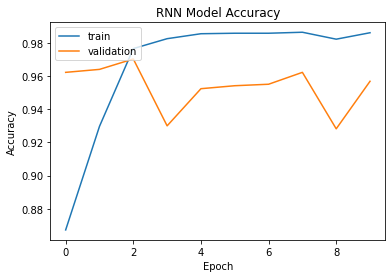

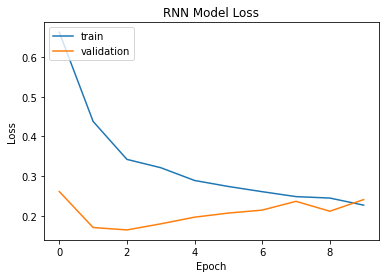

In [ ]:
# Creating a Deep Learning model (RNN) to classify the SMS
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


def create_rnn_model(embedding_input_dimension: int):
  """
  Creates a RNN model to classify the SMS data

  :param embedding_input_dimension: the input dimension for the Embedding layer
  :type embedding_input_dimension: int
  :return model: a compiled RNN model
  :rtype: tensorflow.keras.engine.sequential.Sequential
  """
  model = Sequential()
  # input_dim = vocabulary_size + 1, mask_zero = True -> inform the model that there are padded zeros (previously we used pad_sequences)
  model.add(Embedding(input_dim=embedding_input_dimension, output_dim=64, mask_zero=True))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dense(units=64, activation='relu'))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dense(units=24, activation='relu'))
  model.add(Dense(units=16, activation='relu'))
  model.add(Dense(units=8, activation='relu'))
  model.add(Dense(units=4, activation='relu'))
  model.add(Dense(units=2, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(optimizer=Adam(0.0007), loss=binary_crossentropy, metrics=['acc'])

  return model


if __name__ == '__main__':
  rnn_model = create_rnn_model(len(vocabulary) + 1)

  keras_train_X = np.array(keras_train_X)
  keras_validation_X = np.array(keras_validation_X)
  keras_test_X = np.array(keras_test_X)
  validation_Y = np.array(validation_Y)

  history = rnn_model.fit(keras_train_X, train_Y, validation_data=(keras_validation_X, validation_Y), batch_size=32, verbose=1, epochs=10, class_weight=class_weights)

  test_metrics = rnn_model.evaluate(keras_test_X, test_Y, verbose=0)
  test_accuracy = test_metrics[rnn_model.metrics_names.index('acc')]
  print(f'Accuracy with test data: {round(test_accuracy, 4)}')

  print('')

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('RNN Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  print('')

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('RNN Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()